In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import tensorflow as tf
import seaborn as sns

%matplotlib inline

In [ ]:
def func(x):
  """
  The Goldstein-Price function
  https://www.sfu.ca/~ssurjano/goldpr.html
  """
  x1, x2 = x[0], x[1]

  fact1a = (x1 + x2 + 1) ** 2
  fact1b = 19 - 14*x1 + 3*x1 ** 2 - 14*x2 + 6*x1*x2 + 3*x2 ** 2
  fact1 = 1 + fact1a*fact1b

  fact2a = (2*x1 - 3*x2)**2
  fact2b = 18 - 32*x1 + 12*x1**2 + 48*x2 - 36*x1*x2 + 27*x2**2
  fact2 = 30 + fact2a*fact2b

  y = fact1*fact2

  return y

## Аналіз функції

In [ ]:
def plot_3d(xlim, ylim, func, figsize=(15, 8)):
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(projection='3d')
  
  x = np.linspace(*xlim, 50)
  y = np.linspace(*ylim, 50)

  X, Y = np.meshgrid(x, y)
  Z = func([X, Y])

  
  ax.plot_surface(X, Y, Z, cmap="plasma")
  plt.show()

In [ ]:
def plot_2d(xlim, ylim, func, mean=None, solutions=None, figsize=(15, 8), fig=None, ax=None):
  if fig is None:
    fig = plt.figure(figsize=figsize)
    
  if ax is None:
    ax = fig.add_subplot(111)

  x = np.linspace(*xlim, 50)
  y = np.linspace(*ylim, 50)

  X, Y = np.meshgrid(x, y)
  Z = func([X, Y])

  ax.set_xlabel('X axis')
  ax.set_ylabel('Y axis')

  if mean is not None:
    ax.plot(mean[0],
            mean[1],
            marker='+',
            color='black',
            markersize=12,
            linestyle='None',
            label='mean')
    
  if solutions is None:
        solutions = []

  mu = int(np.floor(len(solutions) / 2))
  for i, solution in enumerate(solutions):
    if i == 0:
      label = 'population (selected)'
    elif i == mu:
      label = 'population (discarded)'
    else:
      label = None
    
    ax.plot(solution[0], solution[1],
            marker='o', color='white',
            markersize=8 if (i+1) <= len(solutions) / 2 else 5,
            linestyle='None',
            markeredgecolor='grey' if (i+1) <= len(solutions) / 2 else None,
            label=label)

  cs = ax.contourf(X, Y, Z, levels=25, cmap='plasma')

  return fig, ax

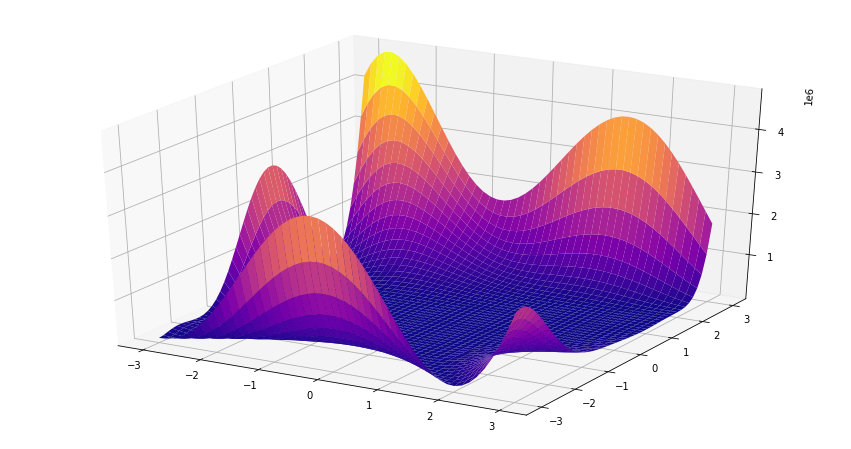

In [ ]:
xlim, ylim = [-3, 3], [-3, 3]
plot_3d(xlim, ylim, func)

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1e80a6f970>)

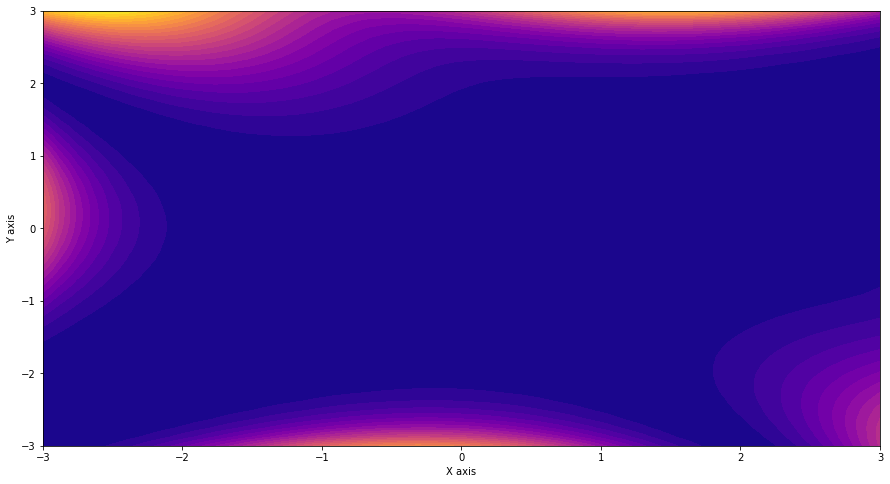

In [ ]:
plot_2d(xlim, ylim, func)

# Метод CMA-ES

In [ ]:
!pip install cma-es
from cma import CMA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def fitness_fn(x):
    return func([x[:,0], x[:,1]])


## Дослідимо як впливає розмір популяції на результат


#### Для population_size=5

In [ ]:
cma = CMA(
    initial_solution=[1.5, -0.4],
    initial_step_size=1.0,
    fitness_function=fitness_fn,
    store_trace=True,
    population_size=5
)

In [ ]:
%%time
best_solution, best_fitness = cma.search()

print('Number of generations:', cma.generation)
print(f'Best solution: [{best_solution[0]:.5f}, {best_solution[1]:.5f}]')
print(f'Best fitness: {best_fitness:.4f}')

Number of generations: 68
Best solution: [-0.00014, -1.00005]
Best fitness: 3.0000
CPU times: user 1.27 s, sys: 48.7 ms, total: 1.32 s
Wall time: 1.33 s


In [ ]:
def plot_mean_coordinates(trace, num_columns=2, figsize=(15, 6)):
    means = np.vstack([t['m'] for t in trace])
    generations = range(len(means))

    num_rows = int(np.ceil(means.shape[1] / num_columns))
    _fig_size = (figsize[0], figsize[1] * num_rows)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=_fig_size)
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= means.shape[1]:
            ax.remove()
            continue

        ax.plot(generations, means[:,i])
        ax.set_xlabel('Generation')
        ax.set_title(f'$X_{i+1}$')
        ax.grid(True)

    fig.suptitle('Evolution of the mean\n', fontsize='x-large');

    return fig, axes

(<Figure size 1080x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e0389db50>,
       dtype=object))

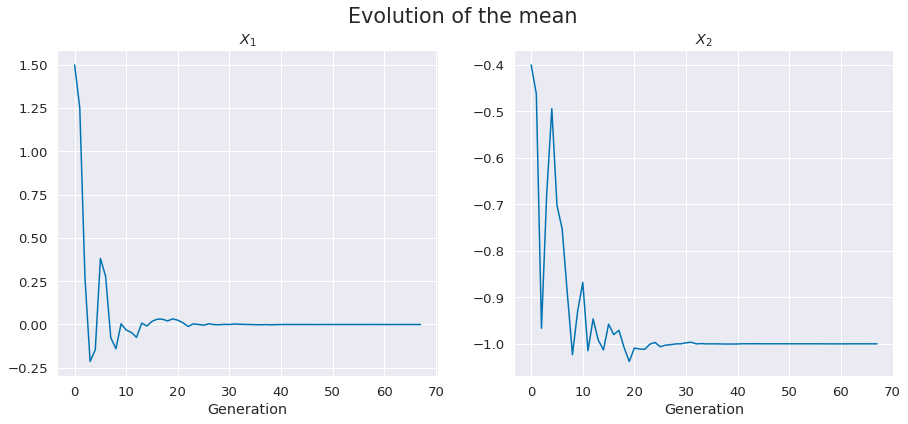

In [ ]:
sns.set(palette='colorblind', font_scale=1.2)
plot_mean_coordinates(cma.trace)

In [ ]:
def angle_rad(u, v):
    """
    Counter-clockwise angle in radian between vectors u and v.
    """
    a = u / np.linalg.norm(u, 2)
    b = v / np.linalg.norm(v, 2)
    return np.arctan2(
        a[0] * b[1] - a[1] * b[0],
        a[0] * b[0] + a[1] * b[1],
    )

In [ ]:
def angle_deg(u, v):
    """
    Counter-clockwise angle in degrees between vectors u and v.
    """
    return angle_rad(u, v) * (180 / np.pi)

In [ ]:
from matplotlib.patches import Ellipse
from scipy.stats import chi2


def draw_confidence_ellipse(ax, mean, eigenvectors, eigenvalues, 
                            confidence=0.95,facecolor='None',edgecolor='black'):
    """
    Draw a covariance error ellipse, i.e. an iso-contour of the multivariate normal distribution.
    A 95% confidence ellipse (default) shows where 95% of sampled points will fall.
    Ref: https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
    """
    if not np.isscalar(confidence) or confidence <= 0 or confidence >= 1:
        raise ValueError('Confidence must be a number between 0 and 1')

    chi2_val = chi2.isf(q=1. - confidence, df=2)

    width = 2 * np.sqrt(chi2_val * eigenvalues[0])
    height = 2 * np.sqrt(chi2_val * eigenvalues[1])

    # Counter clockwise angle in degrees between the y-axis and the
    # second principal axis of the covariance matrix.
    # Note: the angle between the x-axis and the first principal axis is the same,
    # thus angle_deg([1, 0], eigenvectors[0]) is equivalent
    angle = angle_deg([0, 1], eigenvectors[1])

    ellipse = Ellipse(xy=(mean[0], mean[1]),
                      width=width, height=height, angle=angle,
                      facecolor=facecolor, edgecolor=edgecolor)
    
    ax.add_patch(ellipse);


### Хід еволюції


In [ ]:
from matplotlib.ticker import FormatStrFormatter

def plot_generations(generations, cma_trace, fitness_fn, xlim, ylim, num_columns=3):
    num_rows = int(np.ceil(len(generations) / num_columns))
    f, axes = plt.subplots(num_rows, num_columns,
                           sharex=True, sharey=True,
                           figsize=(16, 5 * num_rows))

    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i >= len(generations):
            ax.remove()
            continue

        generation = generations[i]
        trace = cma_trace[generation]
        m = trace['m']
        B = trace['B']
        l = trace['σ']**2 * np.diagonal(trace['D'])**2
        population = trace['population']

        plot_2d(xlim, ylim, fitness_fn, mean=m, solutions=population, fig=f, ax=ax)

        draw_confidence_ellipse(ax, m, B, l)
        
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.get_xaxis().set_major_formatter(FormatStrFormatter('%.2f'))
        ax.get_yaxis().set_major_formatter(FormatStrFormatter('%.2f'))
        ax.set_title(f'Generation {generation}')

    return f, axes


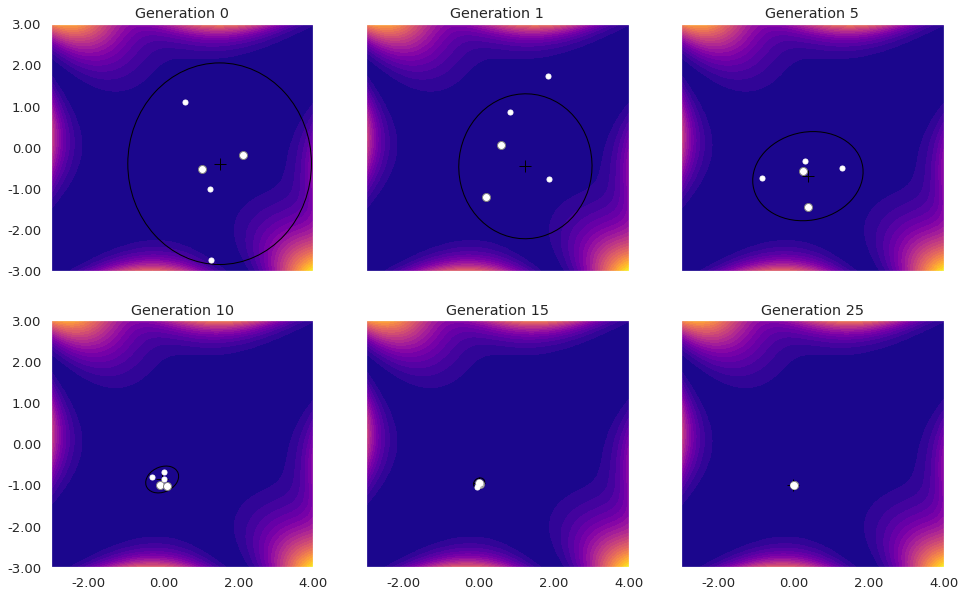

In [ ]:
generations = [0, 1, 5, 10, 15, 25]
fig, _ = plot_generations(generations, cma.trace,
                          func, xlim=[-3, 4], ylim=[-3, 3])

#### Для population_size=15

In [ ]:
cma = CMA(
    initial_solution=[1.5, -0.4],
    initial_step_size=1.0,
    fitness_function=fitness_fn,
    store_trace=True,
    population_size=15
)

In [ ]:
%%time
best_solution, best_fitness = cma.search()

print('Number of generations:', cma.generation)
print(f'Best solution: [{best_solution[0]:.5f}, {best_solution[1]:.5f}]')
print(f'Best fitness: {best_fitness:.4f}')

Number of generations: 38
Best solution: [0.00004, -1.00002]
Best fitness: 3.0000
CPU times: user 1.09 s, sys: 46.6 ms, total: 1.14 s
Wall time: 1.07 s


(<Figure size 1080x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e034416a0>,
       dtype=object))

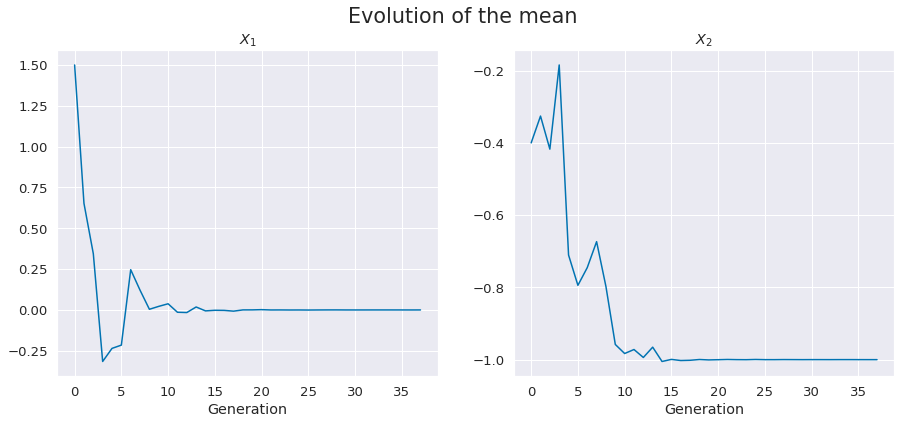

In [ ]:
sns.set(palette='colorblind', font_scale=1.2)
plot_mean_coordinates(cma.trace)

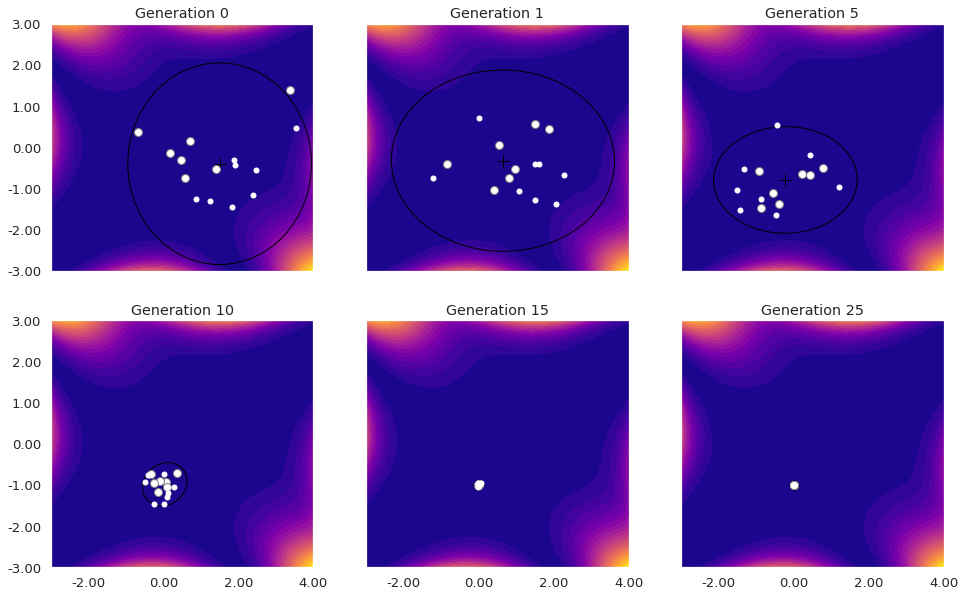

In [ ]:
generations = [0, 1, 5, 10, 15, 25]
fig, _ = plot_generations(generations, cma.trace,
                          func, xlim=[-3, 4], ylim=[-3, 3])

#### Для population_size=50

In [ ]:
cma = CMA(
    initial_solution=[1.5, -0.4],
    initial_step_size=1.0,
    fitness_function=fitness_fn,
    store_trace=True,
    population_size=50
)

In [ ]:
%%time
best_solution, best_fitness = cma.search()

print('Number of generations:', cma.generation)
print(f'Best solution: [{best_solution[0]:.5f}, {best_solution[1]:.5f}]')
print(f'Best fitness: {best_fitness:.4f}')

Number of generations: 18
Best solution: [0.00005, -1.00001]
Best fitness: 3.0000
CPU times: user 1.17 s, sys: 60.6 ms, total: 1.23 s
Wall time: 1.13 s


(<Figure size 1080x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e03480b20>,
       dtype=object))

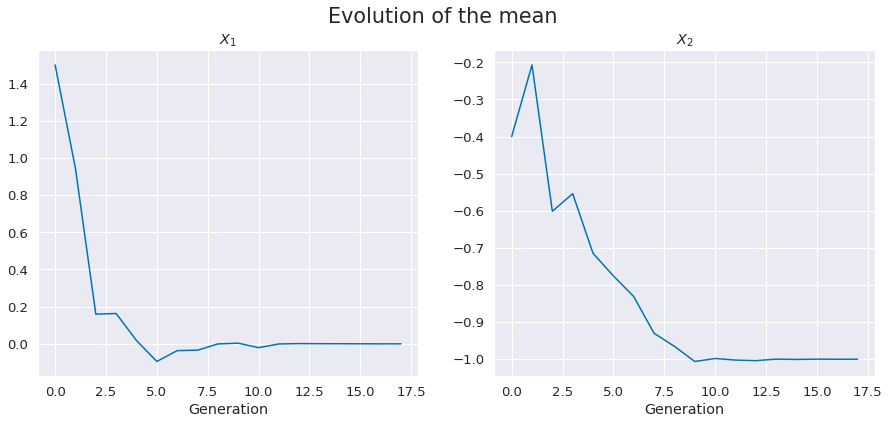

In [ ]:
sns.set(palette='colorblind', font_scale=1.2)
plot_mean_coordinates(cma.trace)

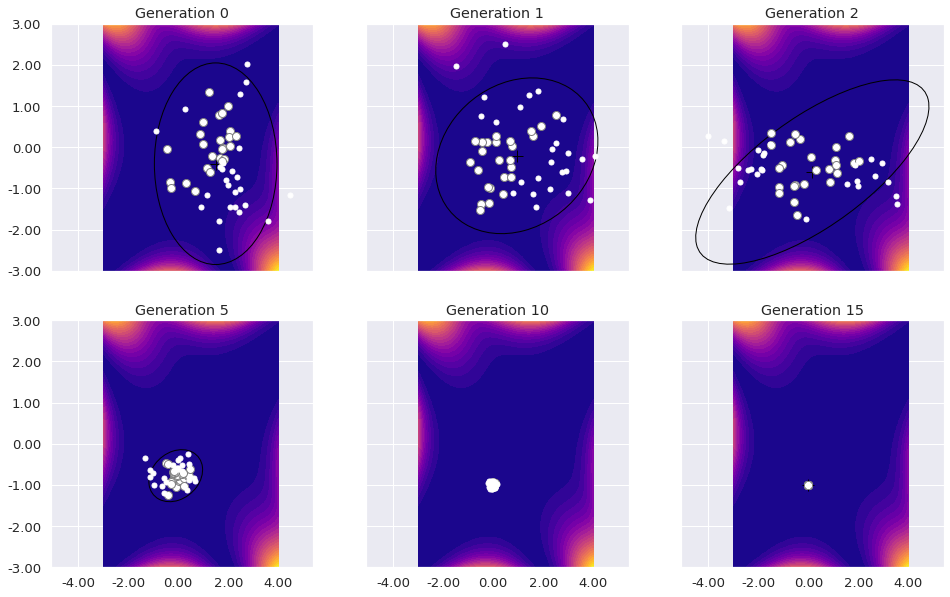

In [ ]:
generations = [0, 1, 2, 5, 10, 15]
fig, _ = plot_generations(generations, cma.trace,
                          func, xlim=[-3, 4], ylim=[-3, 3])

Для розміру поколінь:


- 5
  - Кількість поколінь: 68
  - Час пошуку: 1.32 s
- 15
  - Кількість поколінь: 38
  - Час пошуку: 1.14 s
- 50
  - Кількість поколінь: 18
  - Час пошуку: 1.23 s






In [ ]:
cma = CMA(
    initial_solution=[5,5],
    initial_step_size=1.0,
    fitness_function=fitness_fn,
    store_trace=True,
    population_size=10
)

In [ ]:
%%time
best_solution, best_fitness = cma.search()

print('Number of generations:', cma.generation)
print(f'Best solution: [{best_solution[0]:.5f}, {best_solution[1]:.5f}]')
print(f'Best fitness: {best_fitness:.4f}')

Number of generations: 54
Best solution: [-0.00005, -0.99999]
Best fitness: 3.0000
CPU times: user 1.58 s, sys: 46.6 ms, total: 1.63 s
Wall time: 1.71 s


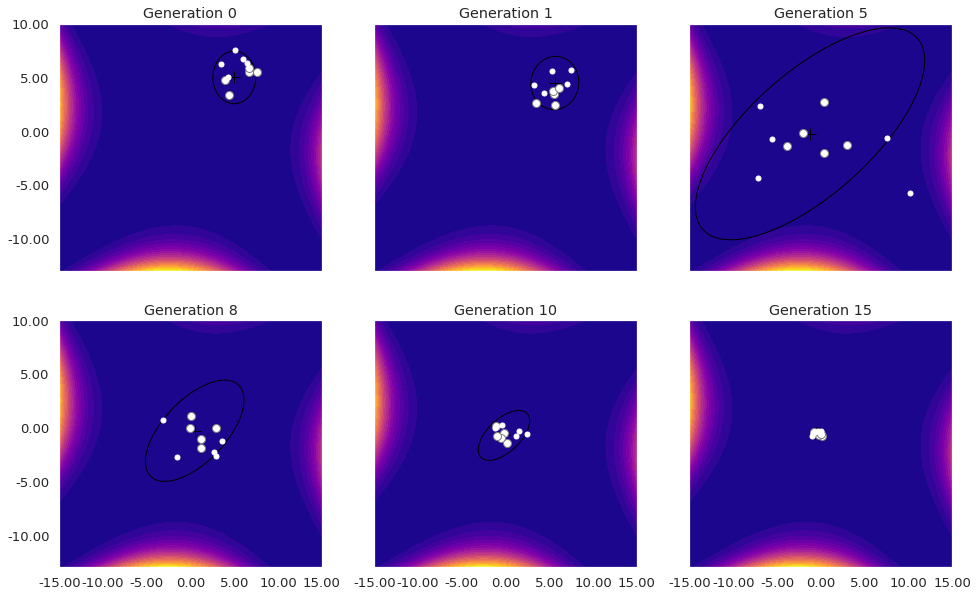

In [ ]:
generations = [0, 1, 5, 8, 10, 15]
fig, _ = plot_generations(generations, cma.trace,
                          func, xlim=[-15, 15], ylim=[-13, 10])

# Генетичний алгоритм

In [ ]:
!pip install pygad
import pygad

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 4.4 MB/s 


In [ ]:
"""
Генетичний алгоритм лише максимізує фітнес функцію, тоді як нашу треба мінімізувати.
Тому ми множимо її на -1
"""

def fit_fn(x, x_ind):
  return 1/func(x)

In [ ]:
def on_generation(ga):
    print("Generation", ga.generations_completed)
    print(ga.population)

Parameters of the best solution : -0.008411943924732324 ,  -1.0004131318295781
Fitness value of the best solution = 3.017144992974522


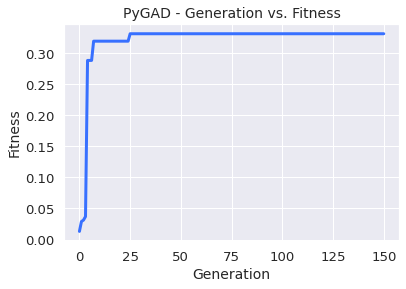

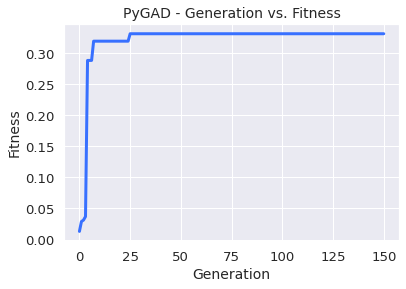

In [ ]:
"""
Вибір батьків пропорційно їх значеню функцій пристосованості.
Ймовірність мутацій = 1
При мутації ми до гена додаємо випадкове число з розподілу U(-1, 1)

"""
genetic_instance1 = pygad.GA(num_generations = 150,
                            num_parents_mating = 30,
                            fitness_func = fit_fn,
                            sol_per_pop = 60,
                            num_genes = 2,
                            init_range_low = -4,
                            init_range_high = 4,
                            parent_selection_type = "rws",
                            crossover_type="single_point",
                            mutation_probability = 1,
                            random_mutation_min_val = -1,
                            random_mutation_max_val = 1,
                            save_solutions = True,
                            suppress_warnings = True  # Не друкуємо попередження (Warnings)
                            )
genetic_instance1.run()
solution, solution_fitness, solution_idx = genetic_instance1.best_solution()
print("Parameters of the best solution :", solution[0], ', ', solution[1])
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=1/solution_fitness))
genetic_instance1.plot_fitness()

Parameters of the best solution : -0.0027531588491409506 ,  -1.000689516253145
Fitness value of the best solution = 3.00170729327409


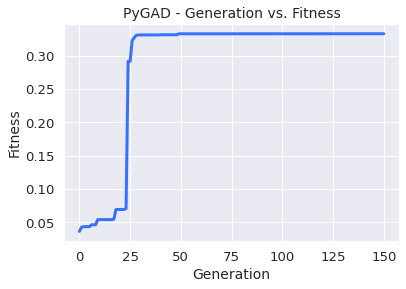

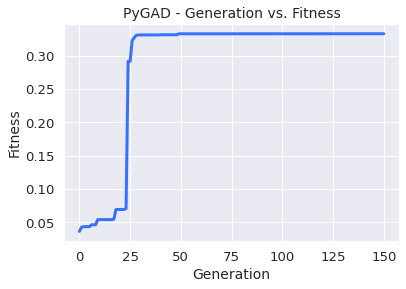

In [ ]:
"""
Вибір батьків пропорційно їх значеню функцій пристосованості.
Ймовірність мутацій = 0.01
При мутації ми до гена додаємо випадкове число з розподілу U(-0.1, 0.1)

"""
genetic_instance2 = pygad.GA(num_generations = 150,
                            num_parents_mating = 30,
                            fitness_func = fit_fn,
                            sol_per_pop = 60,
                            num_genes = 2,
                            init_range_low = -4,
                            init_range_high = 4,
                            parent_selection_type = "rws",
                            crossover_type="single_point",
                            mutation_probability = 0.1,
                            random_mutation_min_val = -0.1,
                            random_mutation_max_val = 0.1,
                            save_solutions = True,
                            suppress_warnings = True  # Не друкуємо попередження (Warnings)
                            )
genetic_instance2.run()
solution, solution_fitness, solution_idx = genetic_instance2.best_solution()
print("Parameters of the best solution :", solution[0], ', ', solution[1])
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=1/solution_fitness))
genetic_instance2.plot_fitness()

Parameters of the best solution : 0.30371616783921684 ,  -0.7961432622936444
Fitness value of the best solution = 23.580292191930937


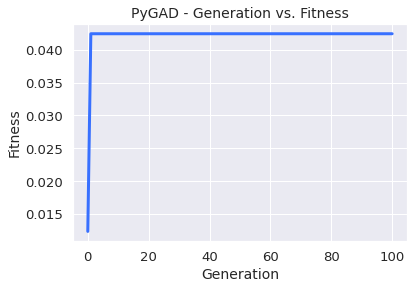

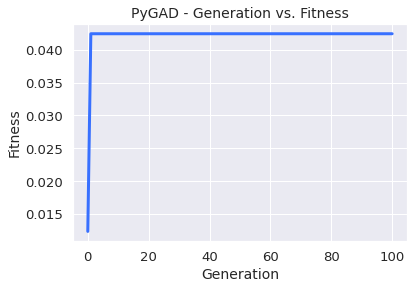

In [ ]:
"""
Вибір батьків пропорційно їх значеню функцій пристосованості.
Мутації відсутні

"""
genetic_instance1 = pygad.GA(num_generations = 100,
                            num_parents_mating = 30,
                            fitness_func = fit_fn,
                            sol_per_pop = 60,
                            num_genes = 2,
                            init_range_low = -4,
                            init_range_high = 4,
                            parent_selection_type = "rws",
                            crossover_type="single_point",
                            mutation_probability = 0,
                            save_solutions = True,
                            suppress_warnings = True  # Не друкуємо попередження (Warnings)
                            )
genetic_instance1.run()
solution, solution_fitness, solution_idx = genetic_instance1.best_solution()
print("Parameters of the best solution :", solution[0], ', ', solution[1])
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=1/solution_fitness))
genetic_instance1.plot_fitness()

Parameters of the best solution : 0.01971002985274084 ,  -0.9999522137349259
Fitness value of the best solution = 3.099242247218548


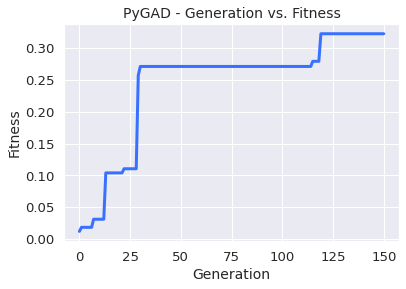

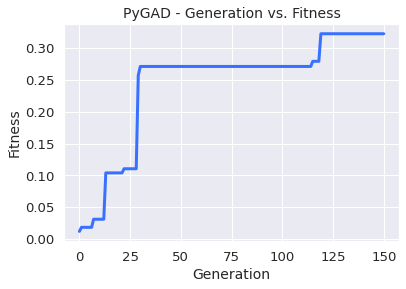

In [ ]:
"""
Вибір батьків є випадковим.
Ймовірність мутацій = 1
При мутації ми до гена додаємо випадкове число з розподілу U(-1, 1)

"""
genetic_instance = pygad.GA(num_generations = 150,
                            num_parents_mating = 30,
                            fitness_func = fit_fn,
                            sol_per_pop = 60,
                            num_genes = 2,
                            init_range_low = -4,
                            init_range_high = 4,
                            parent_selection_type = "random",
                            crossover_type="single_point",
                            mutation_probability = 1,
                            random_mutation_min_val = -1,
                            random_mutation_max_val = 1,
                            save_solutions = True,
                            suppress_warnings = True  # Не друкуємо попередження (Warnings)
                            )
genetic_instance.run()
solution, solution_fitness, solution_idx = genetic_instance.best_solution()
print("Parameters of the best solution :", solution[0], ', ', solution[1])
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=1/solution_fitness))
genetic_instance.plot_fitness()

Parameters of the best solution : -0.0014397473925644028 ,  -1.0006245445685742
Fitness value of the best solution = 3.000497156972784


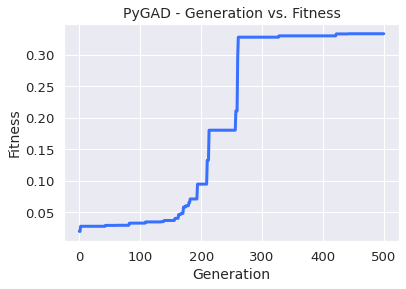

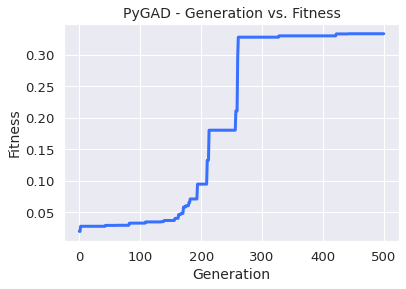

In [ ]:
"""
Вибір батьків є випадковим.
Ймовірність мутацій = 0.01
При мутації ми до гена додаємо випадкове число з розподілу U(-0.1, 0.1)

"""
genetic_instance = pygad.GA(num_generations = 500,
                            num_parents_mating = 30,
                            fitness_func = fit_fn,
                            sol_per_pop = 60,
                            num_genes = 2,
                            init_range_low = -4,
                            init_range_high = 4,
                            parent_selection_type = "random",
                            crossover_type="single_point",
                            mutation_probability = 0.01,
                            random_mutation_min_val = -0.1,
                            random_mutation_max_val = 0.1,
                            save_solutions = True,
                            suppress_warnings = True  # Не друкуємо попередження (Warnings)
                            )
genetic_instance.run()
solution, solution_fitness, solution_idx = genetic_instance.best_solution()
print("Parameters of the best solution :", solution[0], ', ', solution[1])
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=1/solution_fitness))
genetic_instance.plot_fitness()

## Висновок

Під час виконання даної лабораторної роботи було оптимізовано функцію Гольдштейна-Прайса за допомогою алгоритму CMA-ES та генетичного алгоритму з різними параметрами. Так розмір популяції впливає на кількість генерацій та час пошуку оптимального розв'язку<br>

Також було досліджено вплив на роботу алгоритму ймовірнісного механізму вибору батьківських пар,  кроссоверу, мутації,  їх ефективність і доцільність. Додатково було побудовано графіки, які дозволили більш детально проаналізувати продуктивность та ефективность різних методів та їх комбінацій.